# KIBAMBA MFOUTOU Mairevh Exaucey
# Ingénieur IA & Big Data
 ## mairevhlfoutou@gmail.com


## Transformers

Source: L'introduction est pompée sur [un article de Pierre Guillou](https://medium.com/@pierre_guillou/nlp-fastai-transformer-model-8a28b40f6da) lui même inspiré d'un article de [Jay Alammar](http://jalammar.github.io/illustrated-transformer/)



## Introduction


### Historique


Les modèles Seq2Seq mixant RNNs et mécanisme d’attention ont été proposés dès 2014, notamment par Yoshua Bengio dans l'article "Neural Machine Translation by Jointly Learning to Align and Translate". Ils ont permis d’ouvrir un nouveau champ de recherche, en particulier en NLP (Natural language Processing) en montrant que les modèles de Deep Learning surpassaient les performances de modèles plus anciens dans des tâches comme

* la traduction
* la création de titres ou de résumés
* l'analyse des sentiments (ex: détection de commentaires haineux)
* la création de légendes  d'images


Cependant, la nature séquentielle des RNNs a ensuite été  identifiée comme un frein pour l’entraînement des modèles sur des textes longs, à la fois pour des questions de temps d'entrainement (les modèles séquentiel sont dur à paralleliser) et de perte d'information (malgré les astucieux  LSTM et GRU).

Après une période qui a vu l’utilisation de convolutions dynamiques (WaveNet, ByteNet…) permettant un traitement  parallèle de l’ensemble des mots d’une séquence à encoder, le modèle Transformer de Google présenté en juin 2017 dans le papier “Attention Is All You Need” a révolutionné à la fois l’encodage d’une séquence mais aussi le mécanisme d’attention à utiliser :

* l’encodage n’est plus séquentiel mais matriciel. Ainsi le transformer permet de faire davantage de calculs en parallèle, ce qui le rend plus rapide à entraîner que les modèles basés sur les RNNs.

* le mécanisme d’attention n’est plus unique mais se répète 3 fois: L’intuition derrière cela correspond sensiblement à ce que fait un humain:

1. encoder-encoder: il faut comprendre un texte pour pouvoir le traduire
2. encoder-decoder: il faut faire davantage attention à certaines parties de la séquence d’entrée au moment de générer un nouveau mot de la traduction
3. decoder-decoder: il faut faire attention à ce que l’on vient de traduire pour continuer la traduction



### Les transformers géant

Avant d’étudier le fonctionnement du modèle Transformer, il est intéressant de constater à quel point ce modèle a impacté jusqu’à aujourd’hui la recherche en NLP.

En effet, depuis 2017 et le premier modèle Transformer, de nombreux modèles ont été développés par tous les grands laboratoires en Intelligence Artificielle et les GAFAMs.


Les modèles les plus célèbres sont :
* GPT3 d'openAI qui est utilisé dans ChatGPT
* Bert de Google (devenu maintenant Bard)
* RoBERTa (basé sur Bert) de facebook
* Camenbert (basé sur Bert) dont la particularité est ...

C'est la course au plus grand nombre de paramètres:

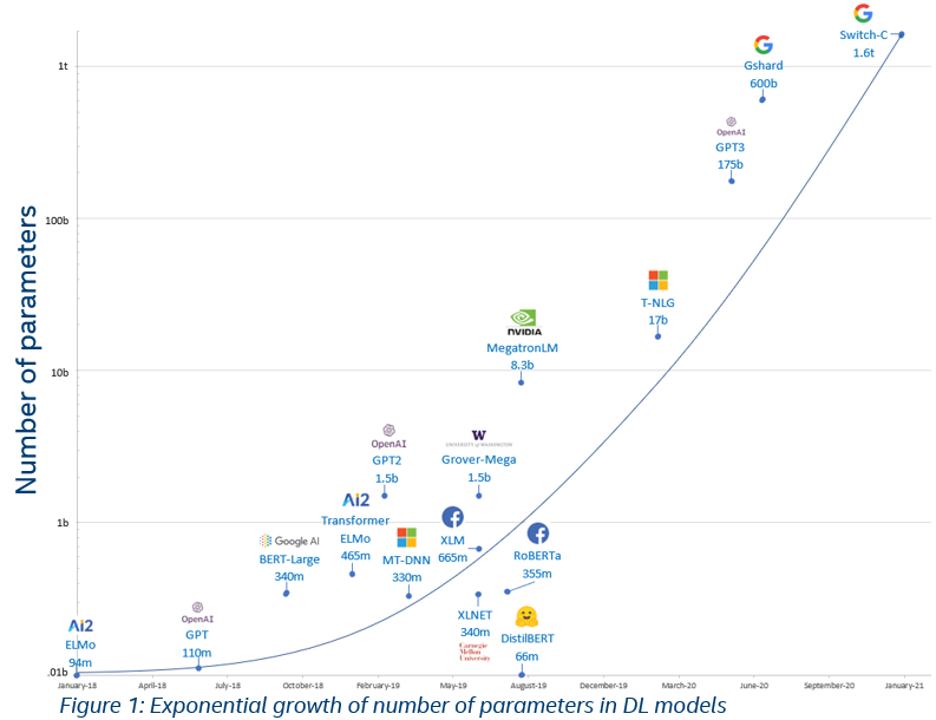

#   Début du tuto tensorflow

## Blabla

On va créer et entrainer un transformer pour effectuer des traduction du portuguais vers l'anglais.



L'idée centrale du modèle Transformer est l'attention, c'est-à-dire la capacité de s'intéresser à différentes positions de la séquence d'entrée pour calculer une représentation de cette séquence.  Ce mécanisme présente les avantages suivants:

* il s'adapte à tout type de relations entre les éléments de la séquence: temporelle, spatiale, autre. Par exemple, chaque élément peut être une  [unité de combat du jeu StarCraft](https://deepmind.com/blog/alphastar-mastering-real-time-strategy-game-starcraft-ii/#block-8).

* Dans un réseau convolutif ou récurent, la relation entre les éléments doit être "homogène". Par exemple $X_{t_0},X_{t_1},X_{t_2},...$ avec des $t_i$ espacés régulièrement. L'attention a moins besoin de cette homogénéité.

* Dans un transformer, les sorties des couches peuvent être calculées en parallèle, au lieu d'une série comme un RNN.

* Des éléments distants peuvent affecter la sortie de l'autre sans passer par de nombreuses étapes RNN ou couches de convolution (voir [Scene Memory Transformer](https://arxiv.org/pdf/1903.03878.pdf) par exemple).

* Il peut apprendre les dépendances à longue portée.

Les inconvénients de cette architecture sont :

* Pour une série temporelle, la sortie au temps $t$ est calculée à partir de l'historique complet, ce qui est couteux comparé à un RNN qui n'utilise que l'état à l'instant $t-1$.

* Si l'entrée a une relation temporelle/spatiale, comme un texte, un encodage positionnel doit être ajouté. Car l'attention n'utilise pas du tout l'ordre des éléments d'une séquence.




## Setup

### Import

In [ ]:
!pip install tensorflow_datasets
!pip install -U tensorflow-text

In [ ]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow as tf

In [ ]:
#logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings
np.set_printoptions(linewidth=10000,precision=3)

### Fonction utile

In [ ]:
def plot_attention_head(in_tokens, translated_tokens, attention):
    # The plot is of the attention when a token was generated.
    # The model didn't generate `<START>` in the output. Skip it.
    translated_tokens = translated_tokens[1:]

    ax = plt.gca()
    ax.matshow(attention)
    ax.set_xticks(range(len(in_tokens)))
    ax.set_yticks(range(len(translated_tokens)))

    labels = [label.decode('utf-8') for label in in_tokens.numpy()]
    ax.set_xticklabels(labels, rotation=90)

    labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
    ax.set_yticklabels(labels)

## Download


Ce jeu de données contient environ 50 000 exemples d'apprentissage, 1 100 exemples de validation et 2 000 exemples de test.

In [ ]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteZY3SL1/ted_hrlr_translate-trai…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteZY3SL1/ted_hrlr_translate-vali…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteZY3SL1/ted_hrlr_translate-test…

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


L'objet `tf.data.Dataset` donne des paires d'exemples de texte :

In [ ]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))

  print()

  for en in en_examples.numpy():
    print(en.decode('utf-8'))

e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


## Preprocessing

### Texte tokenization & detokenization

Vous ne pouvez pas entraîner un modèle directement sur du texte. Le texte doit d'abord être converti en une représentation numérique. Généralement, vous convertissez le texte en séquences d'identifiants: "les tokens" (des entiers) qui sont utilisés comme indices de l'embedding.

On va utiliser des [tokenizer de sous-mot (subword)](https://www.tensorflow.org/text/guide/subwords_tokenizer)  liés à BERT.

In [ ]:
model_name = "ted_hrlr_translate_pt_en_converter"
tf.keras.utils.get_file(
    f"{model_name}.zip",
    f"https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip",
    cache_dir='.', cache_subdir='', extract=True
)

184801/184801 [==============================] - 0s 0us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [ ]:
tokenizers = tf.saved_model.load(model_name)

Le `tf.saved_model` contient deux tokenizers, un pour l'anglais et un pour le portugais. Les deux ont les mêmes méthodes:

In [ ]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

La méthode `tokenize` convertit un lot de chaînes de caractères en un lot de tokens. Cette méthode sépare la ponctuation, les minuscules et normalise l'entrée en unicode avant la tokenisation. Cette normalisation n'est pas visible ici car les données d'entrée sont déjà normalisées.

In [ ]:
for en in en_examples.numpy():
  print(en.decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [ ]:
encoded = tokenizers.en.tokenize(en_examples)

for row in encoded.to_list():
  print(row)

[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


La méthode `detokenize` reconvertit ces tokens en texte lisible par l'homme :

In [ ]:
round_trip = tokenizers.en.detokenize(encoded)
for line in round_trip.numpy():
  print(line.decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


La méthode de bas niveau `lookup` permet de voir à quoi correspond chaque token:

In [ ]:
sub_words_list = tokenizers.en.lookup(encoded)
for sub_word in sub_words_list:
    print(sub_word.numpy())

[b'[START]' b'and' b'when' b'you' b'improve' b'search' b'##ability' b',' b'you' b'actually' b'take' b'away' b'the' b'one' b'advantage' b'of' b'print' b',' b'which' b'is' b's' b'##ere' b'##nd' b'##ip' b'##ity' b'.' b'[END]']
[b'[START]' b'but' b'what' b'if' b'it' b'were' b'active' b'?' b'[END]']
[b'[START]' b'but' b'they' b'did' b'n' b"'" b't' b'test' b'for' b'curiosity' b'.' b'[END]']


Vous pouvez voir ici l'aspect "sous-mot" des tokenizers. Par exemple, le mot "searchability" est décomposé en "search ##ability".

### Configuration du pipeline d'entrée

In [ ]:
def tokenize_pairs(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    # Convert from ragged to dense, padding with zeros.
    pt = pt.to_tensor()

    en = tokenizers.en.tokenize(en)
    # Convert from ragged to dense, padding with zeros.
    en = en.to_tensor()
    return pt, en

Voici un  pipeline d'entrée qui prétraite, mélange et met en batch les données:

In [ ]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [ ]:
def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE))


train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

for x,y in train_batches:
    print("portuguais:\n",x)
    print("anglais:\n",y)
    break

portuguais:
 tf.Tensor(
[[   2  112   83 ...    0    0    0]
 [   2  292   84 ...    0    0    0]
 [   2   40  744 ...    0    0    0]
 ...
 [   2   44  706 ...    0    0    0]
 [   2 1015   14 ...    0    0    0]
 [   2   44  160 ...    0    0    0]], shape=(64, 53), dtype=int64)
anglais:
 tf.Tensor(
[[   2   79    9 ...    0    0    0]
 [   2   74  254 ...    0    0    0]
 [   2  666 2334 ...    0    0    0]
 ...
 [   2   72  605 ...    0    0    0]
 [   2  904   13 ...    0    0    0]
 [   2  110   13 ...    0    0    0]], shape=(64, 75), dtype=int64)


***A vous:*** Est-ce que normal que `x` et `y` n'aient pas les même shape?

### Encodage positionnel

Comme ce modèle ne contient aucune récurrence ou convolution, un encodage positionnel est ajouté pour donner au modèle des informations sur la position relative des mots dans la phrase.

Le vecteur de codage positionnel est concaténé au vecteur d'embedding.

* Deux tokens ont des embedding proche lorsqu'il sont proche au niveau du sens
* Deux tokens on un encodage positionnel proche lorsqu'ils ont des positions proches


La formule pour calculer l'encodage positionnel est la suivante :


$${PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$${PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):

  angle_rads = get_angles(np.arange(position)[:, np.newaxis],np.arange(d_model)[np.newaxis, :],d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)

(1, 2048, 512)


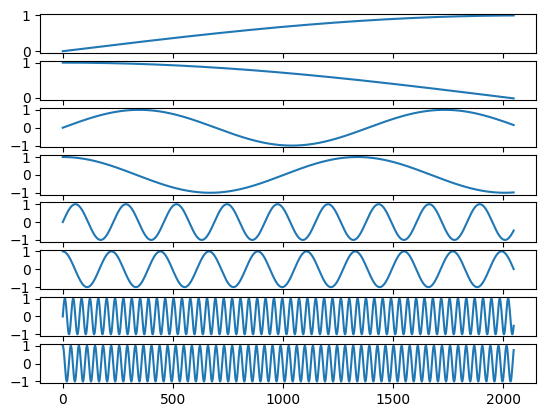

In [ ]:
dims=[400,399,300,299,200,199,100,99]
fig,axs=plt.subplots(len(dims),1,sharex="all")

for i,dim in enumerate(dims):
    axs[i].plot(pos_encoding[0,:,dim])

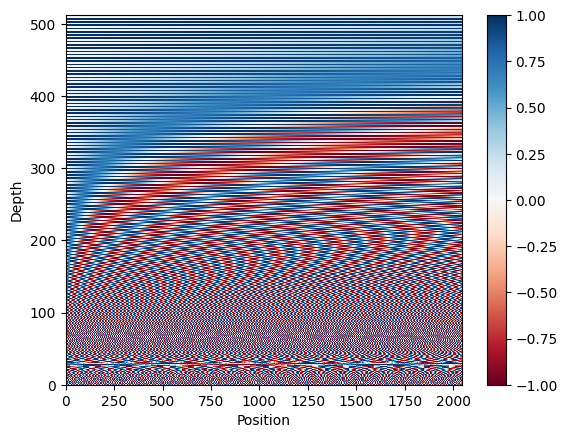

In [ ]:
pos_encoding_ = tf.transpose(pos_encoding[0,:,:])

plt.pcolormesh(pos_encoding_, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar();

## L'attention



### La fonction de l'attention

***A vous:*** Voyez-vous une toute petite différence avec l'implémentation des autres TP?

In [ ]:
def scaled_dot_product_attention(v, k, q, mask):
  """Calculate the attention weights.
  v,k,q must have matching leading (=last) dimensions.
  v,k must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    v: value shape == (..., seq_len_v, depth_v)
    k: key shape == (..., seq_len_k, depth)
    q: query shape == (..., seq_len_q, depth)

    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)


  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)


  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

### Multi-head attention






In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super().__init__()

    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wv = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wq = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    v = self.wv(v)  # (batch_size, seq_len_v, d_model)
    k = self.wk(k)  # (batch_size, seq_len_k, d_model)
    q = self.wq(q)  # (batch_size, seq_len_q, d_model)

    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)

    """
    la scaled_dot_product_attention est appliquée sur les différentes tête.
    Cette fonction agit sur les deux dernière dimensions des tenseurs, qui sont les (seq_len_x, depth)
    """
    scaled_attention, attention_weights = scaled_dot_product_attention(v, k, q, mask)
    # scaled_attention.shape : (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape: (batch_size, num_heads, seq_len_v, seq_len_q)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

def test():
    temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
    y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
    out, attn = temp_mha(y, k=y, q=y, mask=None)
    print(out.shape, attn.shape)
test()


(1, 60, 512) (1, 8, 60, 60)


### Masque de padding

Ce masque binaire contient des `1` aux emplacement situtés après la fin des phrases. Comme on a utilisé un zero-padding, ces non-mots sont représentés par des tokens `0`

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

### Masque anti-anticipation

Le masque look-ahead est utilisé uniquement quand `seq_len_v=seq_len_q`.

Grâce à ce masque, la sortie $Q'_t$ ne dépendra que des $(V,K,Q)_s$ avec $s\leq t$.

In [ ]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

## Réseau dense

En englais on l'appel aussi: Feed Forward. La dimension de sa couche cachée est donc notée `dff`

Il est constinuté de deux couches denses avec une activation `ReLU` entre elles.


In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [ ]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Le modèle

Voici l'architecture globale:

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">


* La phrase d'entrée passe par `N` couches d'encodeurs qui génèrent une sortie pour chaque mot/token de la séquence.
* Le décodeur se sert de la sortie de l'encodeur et de sa propre entrée (auto-attention) pour prédire le mot suivant.



### Un block d'encodage

Elle est constituée 2 de sous-couches :

1.    Attention multi-têtes (avec masque de padding)
2.    Réseaux dense.

Chacune de ces sous-couches est entourée d'une connexion résiduelle suivie d'une normalisation. Ces connexions résiduelles permettent d'éviter le problème de la disparition du gradient (vanishing gradient).
La sortie de chaque sous-couche est `LayerNorm(x + Sublayer(x))`. La normalisation est faite sur l'axe `d_model` (le dernier).




In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super().__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        """
           input x
           :: le dropout
           || la layer normalisation
           h=|:mha(x):+x|
           return |:ff(h):+h|
        """

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        h = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(h)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(h + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2


def test():
    sample_encoder_layer = EncoderLayer(512, 8, 2048)

    sample_encoder_layer_output = sample_encoder_layer(
        tf.random.uniform((64, 43, 512)), False, None)

    print(sample_encoder_layer_output.shape)  # (batch_size, input_seq_len, d_model)
test()

(64, 43, 512)


### Encoder

L'`Encoder` consiste en :
1.   Embedding des tokens d'entrée
2.   Encodage positionnel
3.   N couches d'encodage

La sortie de l'embedding est additionnée avec l'encodage positionnel. Cela donne l'entrée de la première couche d'encodage. Ensuite chaque couche d'encodage se nourit de la sortie de la précédente.


In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self,
               num_layers,
               d_model,
               num_heads,
               dff,
               input_vocab_size, #nombre de token
               maximum_position_encoding, #longueur maximale d'une phrase
               rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding,d_model)

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)


  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) #mis à l'échelle, pour être de la même taille que le position encoding
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)


def test():
    #test
    sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                            dff=2048, input_vocab_size=8500,
                            maximum_position_encoding=10000)
    temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

    sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

    print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

test()


(64, 62, 512)


### Un block de décodage

Chaque couche du décodeur est constituée de 3 sous-couches :

1.   Auto-Attention  masquée, avec un masque "anti-anticipation" et un masque de remplissage (padding)
2.   Attention croisée (avec masque de remplissage). Les entrées V (valeur) et K (clé) sont les sortie de l'encodeur. Tandis que Q (query) est la sortie de la couche de décodage précédente.
3.   Réseaux dense

Chacune de ces 3 sous-couches est entourée d'une connexion résiduelle suivie d'une normalisation de la couche. La sortie de chaque sous-couche est `LayerNorm(x + Sublayer(x))`. La normalisation est faite sur l'axe `d_model` (dernier).

Il y a N couches de décodage dans le transformateur.

***Note:*** Lors de l'attention croisée: les poids d'attention représentent l'importance de l'entrée du décodeur en fonction de la sortie de l'encodeur. En d'autres termes, le décodeur prédit le mot suivant en regardant la sortie de l'encodeur et en se préoccupant lui-même de sa propre sortie.

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)
    """
    x= input_target ou sortie du précédent block de décodage
    enc_output = la sortie de l'encodeur
    training = True ou False
    look_ahead_mask = masque triangulaire
    padding_mask= masque de padding

    notons mha(v,k, q) le layer d'attention.

    Dans cette méthode on calcule :

    """

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2


***A vous:*** Complétez les commentaires de la fonction call, en notant `||` les normalisations et `::` les dropout

### Decoder

Le `Décodeur` se compose de :
1.   D'un embedding des tokens de sortie
2.   D'un encodage positionnel
3.   De N couches de décodage


L'embedding est additionnée à l'encodage positionnel, et se sera l'entrée de la première couche de décodage. Ensuite chaque couche de décodage se nourrit de la précédente et aussi de la sortie du décodeur (qui sert de


In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self,
               num_layers,
               d_model,
               num_heads,
               dff,
               target_vocab_size,
               maximum_position_encoding,
               rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)


  def call(self, x, enc_output, training,look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

### Le Transformer en entier

Le transformateur se compose d'un encodeur, d'un décodeur et d'une couche linéaire finale.

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self,
               num_layers,
               d_model,
               num_heads,
               dff,
               input_vocab_size,
               target_vocab_size,
               maximum_position_encoding_input,
               maximum_position_encoding_target,
               rate=0.1):
    super().__init__()

    self.encoder = Encoder(num_layers,
                           d_model,
                           num_heads,
                           dff,
                           input_vocab_size,
                           maximum_position_encoding_input,
                           rate)

    self.decoder = Decoder(num_layers,
                           d_model,
                           num_heads,
                           dff,
                           target_vocab_size,
                           dff,
                           rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inp, tar, training, enc_padding_mask,
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    # dec_output.shape == (batch_size, tar_seq_len, d_model)

    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

## hyperparamètres

Pour que cet exemple reste petit et rapide à entrainer, les valeurs de `num_layers`, `d_model`, et `dff` ont été réduites.

Les valeurs utilisées dans le modèle de base du transformateur étaient :

* `num_layers`=6
* `d_model` = 512
* `dff` = 2048

Voir ce [papier](https://arxiv.org/abs/1706.03762) pour toutes les autres versions du transformer.

Note : En changeant les valeurs ci-dessous, vous pouvez obtenir ue modèle qui a atteint l'état de l'art sur de nombreuses tâches.

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

## Optimizer

Utilisons l'optimiseur Adam avec un planificateur de taux d'apprentissage (learning rate scheduler) selon la formule de cet [article] (https://arxiv.org/abs/1706.03762).

$${lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$


In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step=tf.cast(step,tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

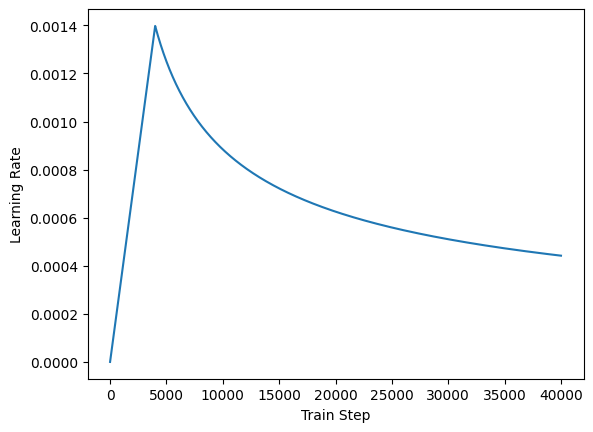

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step");

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,epsilon=1e-9)

## Loss et metrics

Rappel:

* `real` est une suite d'entier :
* `pred` est une suite de vecteur de proba:

        sparse_cross_entropy(real,pred)_i=  -log(pred[i,real[i]])



In [ ]:
import tensorflow as tf
#verif
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')

real=tf.constant([1,0])
pred=tf.constant([[0.2,0.8,0],[0.5,0.5,0]])

print(cross_entropy(real,pred).numpy())

epsilon = 1e-9
print([-tf.math.log(0.8+epsilon).numpy(),-tf.math.log(0.5+epsilon).numpy()])


[0.223 0.693]
[0.22314353, 0.6931472]


* l'option `from_logits=True` indique que `pred` est un vecteur de proba (il est issu d'un softmax)
* l'option `from_logits=False` indique le contraire


In [ ]:
#verif
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

real=tf.constant([1,0])
pred=tf.constant([[12.,5,-1],[3,3,1]])
pred_proba=tf.nn.softmax(pred)

print(cross_entropy(real,pred).numpy())

epsilon = 1e-9
print([-tf.math.log(pred_proba[0,1]+epsilon).numpy(),-tf.math.log(pred_proba[1,0]+epsilon).numpy()])

[7.001 0.759]
[7.0009127, 0.75862366]


Nous allons définir des fonctions  loss et accuray un peu particulières, avec un masque.

***A vous:*** Que font-elle exactement ?


In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    #reduction='none' => évite d'avoir un reduce_sum automatique.

    loss_ = loss_fn(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

## Training et checkpointing

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size(),
    target_vocab_size=tokenizers.en.get_vocab_size(),
    maximum_position_encoding_input=1000,
    maximum_position_encoding_target=1000,
    rate=dropout_rate)

### Création des masque

On aura besoin de 3 masque:
* Un masque pour l'auto-attention de l'encodeur: c'est le masque de padding de l'input (anglais)

* Un masque pour l'auto-attention du décodeur: c'est la combinaison du masque de non-anticipation et du padding de la target (portuguais)

* Un masque pour l'attention croisée. Etant donné que la paire `VK` est l'input, ce sera simplement le masque de padding de l'input (anglais)


In [ ]:
# crée  3 différents masques
def create_masks(inp, tar):
  # Encoder padding mask
  input_padding_mask = create_padding_mask(inp)

  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

  return input_padding_mask, combined_mask, input_padding_mask

Remarquons que dans la fonction précédente on a utilisé uniquement la shape de la target

In [ ]:
inp=tf.constant([[12,4,5,6,0,0]])
tar=tf.constant([[0,2,7,0]])
enc_padding_mask, combined_mask, _=create_masks(inp,tar)

In [ ]:
print(enc_padding_mask.numpy(),enc_padding_mask.shape)

[[[[0. 0. 0. 0. 1. 1.]]]] (1, 1, 1, 6)


In [ ]:
print(combined_mask.numpy(),combined_mask.shape)

[[[[1. 1. 1. 1.]
   [1. 0. 1. 1.]
   [1. 0. 0. 1.]
   [1. 0. 0. 1.]]]] (1, 1, 4, 4)


### Checkpoints

Le checkpoint_manager sauvergardera le modèle toutes les `n` époques.

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

La `target` est divisée en `tar_inp` et `tar_real`.

* `tar_inp` est passé comme une entrée au décodeur.
* `tar_real` est cette même entrée décalée de 1 : à chaque emplacement dans `tar_input`, `tar_real` contient le prochain token qui doit être prédit.

Par exemple,

`sentence` = "SOS A lion in the jungle is sleeping EOS"

    tar_inp =  "SOS  A    lion in  the    jungle is       sleeping"

    tar_real = "A    lion in   the jungle is     sleeping EOS"


Le transformateur est un modèle auto-régressif : il fait des prédictions un "sous-mot" à la fois, et utilise ses résultats précédents pour décider de la suite.

Pendant l'apprentissage, cet exemple utilise le teacher-forcing (comme dans le [tutoriel de génération de texte]. Cela consiste à transmettre la sortie réelle au pas de temps suivant, indépendamment de ce que le modèle prédit au pas de temps actuel.

Quand transformer prédit un mot, l'auto-attention lui permet de regarder les mots précédents dans la séquence d'entrée pour mieux prédire le mot suivant.

Pour empêcher le modèle de regarder la sortie attendue, le modèle utilise un masque d'anti-anticipation.

### Main loop

In [ ]:
EPOCHS = 20

In [ ]:
"""
Les tensur en entrée n'ont pas la même shape d'un batch à l'autre.
Pour éviter de tracer plusieurs fois la fonction décorée, on lui indique que ses entrées sont de shape variable
"""
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]
@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer.call(inp, tar_inp,
                                        True,
                                        enc_padding_mask,
                                        combined_mask,
                                        dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

Le portugais est utilisé comme langue d'entrée et l'anglais comme langue cible.

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')


  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 8.9070 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.8385 Accuracy 0.0032
Epoch 1 Batch 100 Loss 8.7272 Accuracy 0.0227
Epoch 1 Batch 150 Loss 8.6083 Accuracy 0.0299
Epoch 1 Batch 200 Loss 8.4641 Accuracy 0.0339
Epoch 1 Batch 250 Loss 8.2927 Accuracy 0.0371
Epoch 1 Batch 300 Loss 8.1011 Accuracy 0.0439
Epoch 1 Batch 350 Loss 7.9031 Accuracy 0.0506
Epoch 1 Batch 400 Loss 7.7120 Accuracy 0.0572
Epoch 1 Batch 450 Loss 7.5453 Accuracy 0.0640
Epoch 1 Batch 500 Loss 7.3970 Accuracy 0.0714
Epoch 1 Batch 550 Loss 7.2630 Accuracy 0.0790
Epoch 1 Batch 600 Loss 7.1367 Accuracy 0.0869
Epoch 1 Batch 650 Loss 7.0179 Accuracy 0.0947
Epoch 1 Batch 700 Loss 6.9092 Accuracy 0.1016
Epoch 1 Batch 750 Loss 6.8116 Accuracy 0.1077
Epoch 1 Batch 800 Loss 6.7190 Accuracy 0.1137
Epoch 1 Loss 6.7032 Accuracy 0.1147
Time taken for 1 epoch: 218.70 secs

Epoch 2 Batch 0 Loss 5.1993 Accuracy 0.2239
Epoch 2 Batch 50 Loss 5.2243 Accuracy 0.2139
Epoch 2 Batch 100 Loss 5.2074 Accuracy 0.2149
Epoch 2 Batch

## Evaluation

Le décodeur prédit le mot suivant en se basant sur les mots précédents qu'il a prédits. Voici les différentes étapes:

* On encode la phrase d'entrée en utilisant le tokenizer portugais (`tokenizers.pt`). Ceci est l'entrée de l'encodeur qui en fait le traitement.
* L'entrée du décodeur est initialisée au token `[START]`.
* Le `décodeur` produit ensuite les prédictions en regardant la sortie de l'`encodeur` (attention-croisée) et sa propre sortie (auto-attention).
* Le modèle fait des prédictions sur le mot suivant
* On concaténe le mot prédit avec les mots précédents, et cela sert de nouvelle entrée au décodeur.


In [ ]:
def evaluate(sentence, max_length=40):
  # inp sentence is portuguese, hence adding the start and end token
  sentence = tf.convert_to_tensor([sentence])
  sentence = tokenizers.pt.tokenize(sentence).to_tensor()

  encoder_input = sentence

  # as the target is english, the first word to the transformer should be the
  # english start token.
  start, end = tokenizers.en.tokenize([''])[0]
  output = tf.convert_to_tensor([start])
  output = tf.expand_dims(output, 0)

  for i in range(max_length):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)

    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input,
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.argmax(predictions, axis=-1)

    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

    # return the result if the predicted_id is equal to the end token
    if predicted_id == end:
      break

  # output.shape (1, tokens)
  text = tokenizers.en.detokenize(output)[0]  # shape: ()

  tokens = tokenizers.en.lookup(output)[0]

  return text, tokens, attention_weights

In [ ]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [ ]:
sentence = "este é um problema que temos que resolver."
ground_truth = "this is a problem we have to solve ."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem we need to solve .
Ground truth   : this is a problem we have to solve .


In [ ]:
sentence = "os meus vizinhos ouviram sobre esta ideia."
ground_truth = "and my neighboring homes heard about this idea ."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : my neighbors have heard about this idea .
Ground truth   : and my neighboring homes heard about this idea .


In [ ]:
sentence = "vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram."
ground_truth = "so i \'ll just share with you some stories very quickly of some magical things that have happened ."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i ' m going to share with you with some very quickly stories of some magical thing that happened .
Ground truth   : so i 'll just share with you some stories very quickly of some magical things that have happened .


## Attention plots

La fonction `evaluate` renvoie également un dictionnaire des cartes d'attention que vous pouvez utiliser pour visualiser le fonctionnement interne du modèle :

In [ ]:
sentence = "este é o primeiro livro que eu fiz."
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : este é o primeiro livro que eu fiz.
Prediction     : this is the first book i did .
Ground truth   : this is the first book i've ever done.


In [ ]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The plot is of the attention when a token was generated.
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [ ]:
head = 0
# shape: (batch=1, num_heads, seq_len_q, seq_len_k)
attention_heads = tf.squeeze(
  attention_weights['decoder_layer4_block2'], 0)
attention = attention_heads[head]
attention.shape

TensorShape([9, 11])

In [ ]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que', b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

In [ ]:
translated_tokens

<tf.Tensor: shape=(10,), dtype=string, numpy=array([b'[START]', b'this', b'is', b'the', b'first', b'book', b'i', b'did', b'.', b'[END]'], dtype=object)>

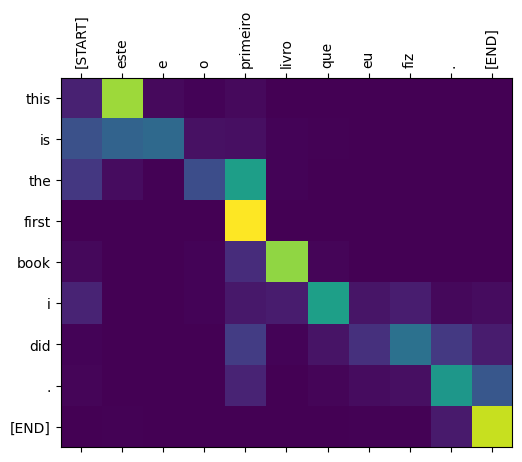

In [ ]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [ ]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]
  in_tokens

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

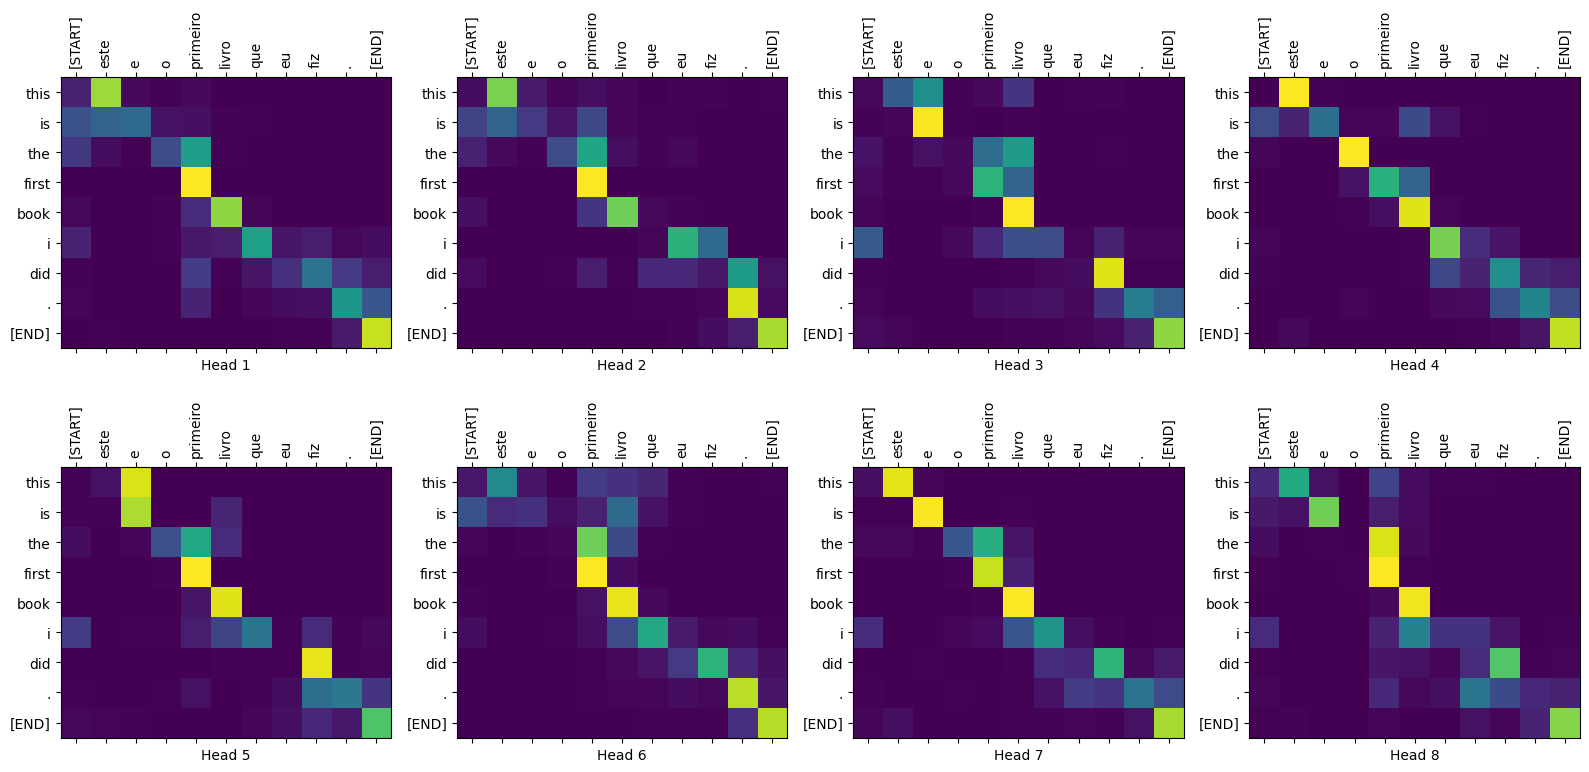

In [ ]:
plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

Le modèle se débrouille bien avec les mots non familiers. Ni "triceratops" ni "encyclopédie" ne figurent dans l'ensemble de données d'entrée et le modèle apprend presque à les translittérer:

Input:         : Eu li sobre triceratops na enciclopédia.
Prediction     : i read about triumphos in the encyclopedia .
Ground truth   : I read about triceratops in the encyclopedia.


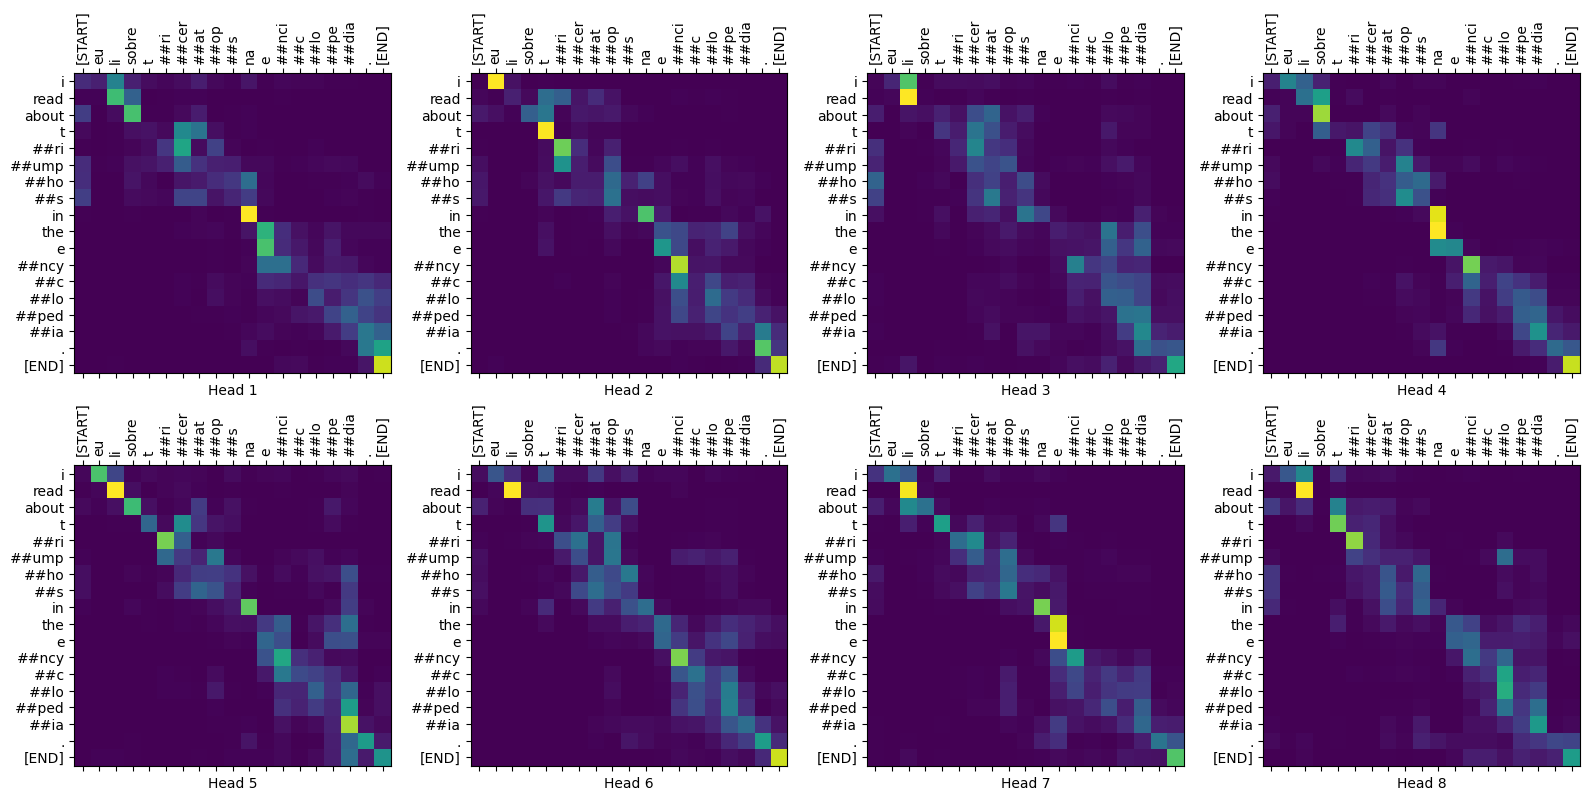

In [ ]:
sentence = "Eu li sobre triceratops na enciclopédia."
ground_truth = "I read about triceratops in the encyclopedia."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

## Suggestion


* Utiliser des données différentes.

* Entrainer le transformater XL en modifiant les hyperparamètres qui réglent la taille du transformer.

* Utiliser des couches prédéfinie de [BERT](https://arxiv.org/abs/1810.04805) (vous pouvez aussi récupérer leur poids).

*  implémenter la [beam search](https://towardsdatascience.com/an-intuitive-explanation-of-beam-search-9b1d744e7a0f) pour obtenir de meilleures prédictions.